REQUIRED LIBRARIES


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import pandas as pd
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

loading dataset


In [6]:
dataset_path = "C:/Users/yashw/Desktop/track_fault_detection/Railway Track fault Detection dataset"
weights_path = "C:/Users/yashw/Downloads/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [7]:
train_dir = os.path.join(dataset_path, "Train")
validation_dir = os.path.join(dataset_path, "Validation")


In [8]:
# Training and validation directories
train_defective_dir = os.path.join(train_dir, "Defective")
train_nondefective_dir = os.path.join(train_dir, "Non defective")
validation_defective_dir = os.path.join(validation_dir, "Defective")
validation_nondefective_dir = os.path.join(validation_dir, "Non defective")


In [9]:
# Print dataset statistics
print(f"Total training defective images: {len(os.listdir(train_defective_dir))}")
print(f"Total training non-defective images: {len(os.listdir(train_nondefective_dir))}")
print(f"Total validation defective images: {len(os.listdir(validation_defective_dir))}")
print(f"Total validation non-defective images: {len(os.listdir(validation_nondefective_dir))}")


Total training defective images: 150
Total training non-defective images: 150
Total validation defective images: 31
Total validation non-defective images: 31


In [10]:
# Display some sample images
nrows, ncols = 4, 4
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

<Figure size 1600x1600 with 0 Axes>

In [11]:

train_defective_fnames = os.listdir(train_defective_dir)
train_nondefective_fnames = os.listdir(train_nondefective_dir)

In [12]:
next_defective_pix = [os.path.join(train_defective_dir, fname) for fname in train_defective_fnames[:8]]
next_nondefective_pix = [os.path.join(train_nondefective_dir, fname) for fname in train_nondefective_fnames[:8]]

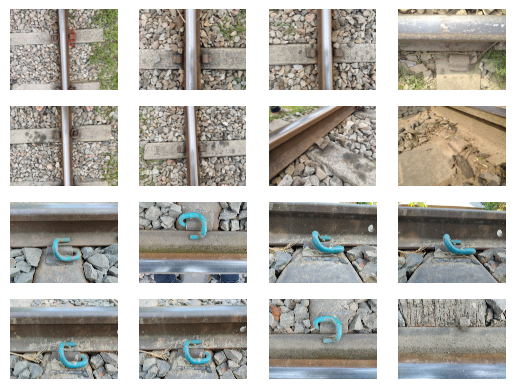

In [13]:
for i, img_path in enumerate(next_defective_pix + next_nondefective_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [14]:
# Load InceptionV3 model
pre_trained_model = InceptionV3(input_shape=(300, 300, 3), include_top=False, weights=None)
pre_trained_model.load_weights(weights_path)


In [15]:
# Freeze layers
for layer in pre_trained_model.layers:
    layer.trainable = False


In [16]:
# Get last layer output
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output


In [17]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [18]:
validation_datagen = ImageDataGenerator(rescale=1./255.)


In [19]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(300, 300))


Found 299 images belonging to 2 classes.


In [20]:
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                               batch_size=20,
                                                               class_mode='binary',
                                                               target_size=(300, 300))


Found 62 images belonging to 2 classes.


In [21]:
# Model Definition
x = layers.Flatten()(last_output)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)



In [22]:
model = Model(pre_trained_model.input, x)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [23]:
# Model summary
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 300, 300, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 149, 149, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 149, 149, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 149, 149, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 147, 147, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 147, 147, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 147, 147, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 147, 147, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 147, 147, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 147, 147, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 73, 73, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 73, 73, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 73, 73, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 73, 73, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 71, 71, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 16,077,793 (61.33 MB)

 Trainable params: 7,102,529 (27.09 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [24]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=25,                            
                              verbose=2)

C:\Users\yashw\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
15/15 - 72s - 5s/step - accuracy: 0.4916 - loss: 1.3963 - val_accuracy: 0.5000 - val_loss: 0.6750
Epoch 2/25
15/15 - 61s - 4s/step - accuracy: 0.5485 - loss: 0.6770 - val_accuracy: 0.5484 - val_loss: 0.6687
Epoch 3/25
15/15 - 59s - 4s/step - accuracy: 0.5719 - loss: 0.6598 - val_accuracy: 0.7419 - val_loss: 0.6153
Epoch 4/25
15/15 - 58s - 4s/step - accuracy: 0.6522 - loss: 0.6509 - val_accuracy: 0.7419 - val_loss: 0.6173
Epoch 5/25
15/15 - 59s - 4s/step - accuracy: 0.6421 - loss: 0.6345 - val_accuracy: 0.6774 - val_loss: 0.6010
Epoch 6/25
15/15 - 58s - 4s/step - accuracy: 0.6823 - loss: 0.6215 - val_accuracy: 0.6452 - val_loss: 0.5857
Epoch 7/25
15/15 - 61s - 4s/step - accuracy: 0.6823 - loss: 0.6153 - val_accuracy: 0.7097 - val_loss: 0.5694
Epoch 8/25
15/15 - 56s - 4s/step - accuracy: 0.6890 - loss: 0.6153 - val_accuracy: 0.8387 - val_loss: 0.5600
Epoch 9/25
15/15 - 55s - 4s/step - accuracy: 0.7258 - loss: 0.6167 - val_accuracy: 0.5645 - val_loss: 0.6074
Epoch 10/25
15/15 -

In [25]:
model.save(r"C:/Users/yashw/Desktop/track_fault_detection/railway_track_fault_model.keras")
print("Model saved successfully in Keras format!")

Model saved successfully in Keras format!


In [26]:
# Plot accuracy and loss
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

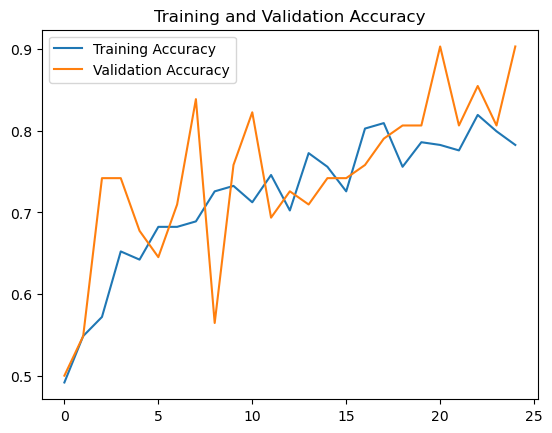

In [27]:
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()



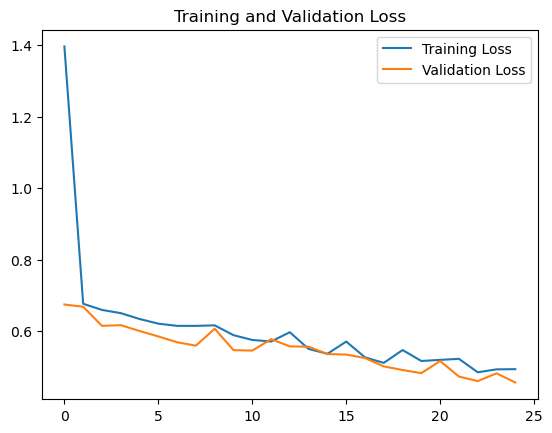

In [28]:
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [29]:
import os

model_path = r"C:/Users/yashw/Desktop/track_fault_detection/railway_track_fault_model.Keras"
print(os.path.exists(model_path))


True


In [35]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])


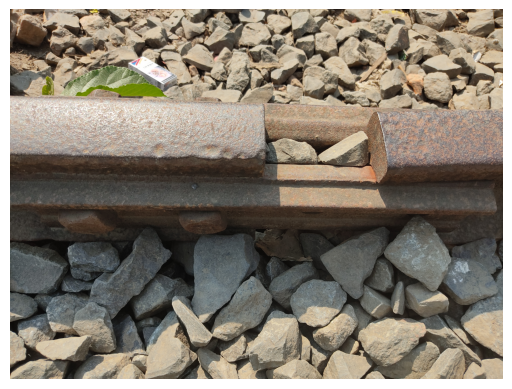

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
❌ This Railway track **HAS a fault**


In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model(r"C:/Users/yashw/Desktop/track_fault_detection/railway_track_fault_model.keras")

# Path to the test image
image_path = r"C:/Users/yashw/Desktop/track_fault_detection/Railway Track fault Detection dataset/Test/Defective/IMG_20201114_102203.jpg"

# Load the image
img = cv2.imread(image_path)

# Convert BGR to RGB for proper visualization
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

# Resize the image to match model input size
img_resized = cv2.resize(img, (300, 300))

# Normalize and reshape
img_array = np.reshape(img_resized, [1, 300, 300, 3]) / 255.0  # Normalizing between 0-1

# Make prediction
prediction = model.predict(img_array)

# Interpret results
if prediction[0][0] > 0.5:  # Adjust threshold based on model training
    print("✅ This Railway track has **NO fault**")
else:
    print("❌ This Railway track **HAS a fault**")


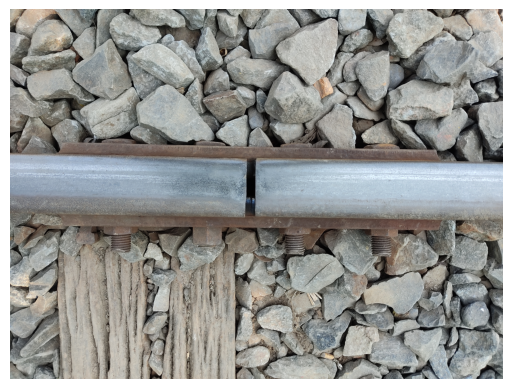

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
✅ This Railway track has **NO fault**


In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model(r"C:/Users/yashw/Desktop/track_fault_detection/railway_track_fault_model.keras")

# Path to the test image
image_path = r"C:/Users/yashw/Desktop/track_fault_detection/Railway Track fault Detection dataset/Test/Non defective/IMG_20201114_100344.jpg"

# Load the image
img = cv2.imread(image_path)

# Convert BGR to RGB for proper visualization
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

# Resize the image to match model input size
img_resized = cv2.resize(img, (300, 300))

# Normalize and reshape
img_array = np.reshape(img_resized, [1, 300, 300, 3]) / 255.0  # Normalizing between 0-1

# Make prediction
prediction = model.predict(img_array)

# Interpret results
if prediction[0][0] > 0.5:  # Adjust threshold based on model training
    print("✅ This Railway track has **NO fault**")
else:
    print("❌ This Railway track **HAS a fault**")


Accuaracy %


In [41]:
print(history.history["val_accuracy"][-1])

0.9032257795333862
